# Getting Everything Set Up

Before you start!

open cmd and run

_conda install ipyparallel_


then start the number of processors you want in a bash window (I used git bash)

_ipcluster start ~n 8_ 


In [1]:
#import necessary libraries
import csv
import numpy as np
import pandas as pd
from patsy import dmatrices

import math as math
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import xgboost
from sklearn import tree, discriminant_analysis, metrics, linear_model, ensemble, naive_bayes, grid_search

from ipyparallel import Client, require
import sys
import time

In [2]:
#set up system timer
if sys.platform == 'win32':
    _timer = time.clock
else:
    _timer = time.time
    
parallelClient = Client()
loadBalancedView = parallelClient.load_balanced_view()


In [3]:
def get_metric(model, target, predictors, metricType):
    #need to add all the metrics
    from sklearn import metrics
   
    predictions = model.predict(predictors)
    PredProb = model.predict_proba(predictors)[:,1]
    fpr, tpr, _ =  metrics.roc_curve(target,PredProb)
    
    metricType = metricType.upper()
    if metricType=="AUC":
        Metric = metrics.auc(fpr,tpr)
    elif metricType =='ACCURACY':
        Metric = metrics.accuracy_score(target,predictions)
    elif metricType =="SCORE":
        Metric =  Score = model.score(predictors, target)
    elif metricType =="LOGLOSS":
        Metric = metrics.log_loss(target,PredProb)
    else: 
        print 'this metric is not in the defined list of metrics'
    return Metric

In [4]:
#the shuffle and fit function
@require (get_metric)
def shuffle_and_fit(model, target, predictors, metricType):
    import random
  
    shuffledTarget = list(target)
    random.shuffle(shuffledTarget)
    if sum(target) != sum(shuffledTarget):
        print 'uh-o something went wrong the numbers pr proportions are not the same in the shuffled list'
    
    model.fit(predictors, shuffledTarget)
    Metric = get_metric(model, shuffledTarget, predictors, metricType)
         
    return Metric

# Read in the Data, Select and Fit the Model, get the REAL metric

In [6]:
# Read in the titanic dataset
data = pd.read_csv('C:/Users/nbruf/Documents/train.csv')
data.head()

# create dataframes with an intercept column and dummy variables for sex
target, predictors = dmatrices('Survived ~ Fare + Age +  Pclass + C(Sex)', data, return_type="dataframe")
print predictors.columns

# flatten y into a 1-D array
target1d = np.ravel(target)

Index([u'Intercept', u'C(Sex)[T.male]', u'Fare', u'Age', u'Pclass'], dtype='object')


In [7]:
#select, define, and fit the model

#model = linear_model.LogisticRegression()
model = tree.DecisionTreeClassifier()
#model = ensemble.RandomForestClassifier()
#model = ensemble.AdaBoostClassifier()
#model = naive_bayes.GaussianNB()

#fit the model
model.fit(predictors, target1d)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [8]:
#get a metric
RealMetric = get_metric(model,target1d,predictors,'AUC')
RealMetric

0.99949170461938841

# Target Shuffle & Plot

In [9]:
#run the simulation to get a bunch more metrics
iterations = 20
histogram = []
simulatedMetrics = []

startTime = _timer()
for shuffleIndex in range(0,iterations):
    simulatedMetrics.append(loadBalancedView.apply(shuffle_and_fit,model, target1d, predictors, 'AUC'))

for item in simulatedMetrics:
    histogram.append(item.get())

endTime = _timer()
duration_in_seconds = endTime - startTime
print('TOTAL TIME IN SECONDS: ' + str(duration_in_seconds))


TOTAL TIME IN SECONDS: 3.12435678987


Simuluation Standard Deviation = 0.0006 
Our Actual Metric is 0.99949
That is 3.48 standard deviations from the mean of the target shuffled models


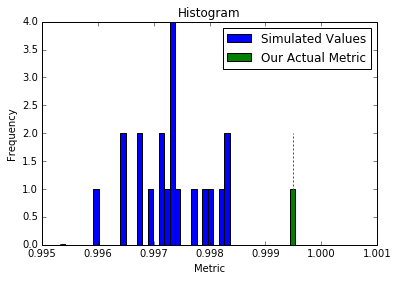

In [11]:
#plot the metrics on a histogram to see how unusual the real model is compared to random simluations
simStdDev = np.std(histogram)
if max(histogram) > RealMetric:
    upper = max(histogram) + simStdDev
else:
    upper = RealMetric + simStdDev
    
if min(histogram) < RealMetric:
    lower = min(histogram) - simStdDev
else:
    lower = RealMetric - simStdDev


print 'Simuluation Standard Deviation = %.4f ' % simStdDev
howUnusual = (RealMetric - np.mean(histogram))/ simStdDev
print 'Our Actual Metric is %.5f' %RealMetric
#would be better to refer to this as X percent rare...
print 'That is %.2f standard deviations from the mean of the target shuffled models' %howUnusual


bins = np.linspace((lower), (upper))
plt.hist(histogram, bins, label='Simulated Values')
plt.hist(RealMetric, bins,label='Our Actual Metric')
plt.legend(loc='upper right')
plt.title("Histogram")
plt.xlabel("Metric")
plt.ylabel("Frequency")
plt.arrow(x=RealMetric, y=0, dx=0.0, dy=(iterations/10), width=(iterations/1000), color='green', linestyle='dotted', label='our metric' )


It needs to be REALLY far from the simulated distribution - 3 standard deviations is not that different.
models can theoreticallly be compared based on which have greater distance from the simulated models.